Boilerplate imports:

In [1]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

In [3]:
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

# Homework 3: uCFD
## From Tony Saad's uCFD Course at University of Utah
### Completed by Matt Williams (matt.williams@alum.mit.edu)
</hr>

#### Problem 1:

Consider the diffusion equation on a unit square, namely:

$$ \nabla u^2 = 0, \Omega =[0,1]x[1,0]$$

subject to the conditions:

$$u[4:n-4,0]=1, u_{boundary}=0$$

Solve the equation numerically using successive over relaxation for a number of coeficients $\beta$, using solution tolerances of $10^{-2}, 10^{-3}, 10^{-4}, 10^{-5}$.

#### Solution:

The discretization of the homogeneous diffusion equation is:

$$\frac{u_{i+1,j}-2u_{ij}+u_{i-1,j}}{\Delta x^{2}} +\frac{u_{i,j+1}-2u_{ij}+u_{i,j-1}}{\Delta y^{2}} =0$$

Solving explicitly for $u_{ij}$ gives:

$$ u_{ij}\  =\  \frac{\Delta y^{2}}{2(\Delta x^{2}+\Delta y^{2})} (u_{i+1,j}+u_{i-1,j})+\frac{\Delta x^{2}}{2(\Delta x^{2}+\Delta y^{2})} (u_{i,j+1}+u_{i,j-1})$$

To get the SOR method, we multiply by $\beta$, and then subtract $u_{ij}$ from both sides. Rearranging gives:

$$u_{ij}\  =\  \beta \frac{\Delta y^{2}}{2(\Delta x^{2}+\Delta y^{2})} (u_{i+1,j}+u_{i-1,j})+\beta \frac{\Delta x^{2}}{2(\Delta x^{2}+\Delta y^{2})} (u_{i,j+1}+u_{i,j-1})+(1-\beta )u_{ij}$$

#### Note on computational speeds

The SOR method cannot be used with NumPy array operations. The Jacobi method, however, can be. Using array operations with the Jacobi method is very fast. In fact, it is the fastest solution method available. However, the Jacobi method can encounter convergence problems. The Gauss-Seidel method is superior to Jacobi in terms of convergence, but the algorithm is slower, since array operations cannot be used. Instead, since each updated variable is used in the next equation, a for loop must be used. An array operation produces a new array, and only the previous iteration values are used. A for loop can use updated values as the loop progresses, and hence for loops are compatible with Gauss-Seidel. The SOR method, although not as fast as an array operation with the Jacobi method, is much faster than standard Gauss-Seidel.

In [4]:
nx = 33
ny = nx
lx = 1.
ly = 1.
dx = lx/(nx-1)
dy = ly/(ny-1)
beta = np.arange(1, 2, 0.1)  # array of values for beta
tol = np.logspace(-5, -2, 4)
maxit = 200

In [5]:
tol

array([1.e-05, 1.e-04, 1.e-03, 1.e-02])

In [6]:
u = np.zeros((ny,nx))
u[4:ny-4,0] = 1.

In [7]:
def laplace2d(u, dx, dy, tol, maxit, β, ny):
    err = 1e3
    it = 0
    u[:,0] = 0
    u[:,-1] = 0
    u[0,:] = 0
    u[-1,:] = 0
    u[4:ny-4,0] = 1.
    while err > tol and it < maxit:
        un = np.copy(u)
        for i in range(1, u.shape[1]-1):
            for j in range(1, u.shape[0]-1):
                rhs = dx**2*(u[j,i+1]+u[j,i-1])+dy**2*(u[j+1,i]+u[j-1,i])
                rhs *= β/2./(dx**2+dy**2)
                u[j,i] = rhs + (1-β)*un[j,i]
        u[:,0] = 0
        u[:,-1] = 0
        u[0,:] = 0
        u[-1,:] = 0
        u[4:ny-4,0] = 1.
        it += 1
        err = np.linalg.norm(u-un)
    return it, err

In [8]:
beta_tol_iter = []
for β in beta:
    for tolerance in tol:
        u = np.zeros((ny,nx))
        u[4:ny-4,0] = 1.
        it, err = laplace2d(u, dx, dy, tolerance, maxit, β, ny)
        beta_tol_iter.append((β, tolerance, it, err))

In [9]:
iters5 = []
iters4 = []
iters3 = []
iters2 = []
for tup in beta_tol_iter:
    b, t, i, e = tup
    if t == 1e-5:
        iters5.append(i)
    elif t == 1e-4:
        iters4.append(i)
    elif t == 1e-3:
        iters3.append(i)
    else:
        iters2.append(i)

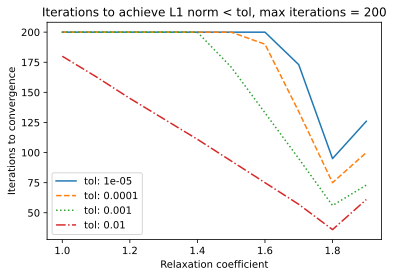

In [10]:
ls = ['-', '--', ':', '-.']
iters = [iters5, iters4, iters3, iters2]
for idx, t in enumerate(tol):
    plt.plot(beta, iters[idx], ls[idx], label=f'tol: {t}')
plt.xlabel('Relaxation coefficient')
plt.ylabel('Iterations to convergence')
plt.title(f'Iterations to achieve L1 norm < tol, max iterations = {maxit}')
plt.legend(loc='best')

#### Results

Based on the values used for the relaxation coefficient, and the given convergence tolerances, a $\beta$ value of 1.8 was the consistent high-performer for this particular problem. Coefficients of less than 1 were not used, as that would be an underrelaxation problem.

The tighter tolerances initially did not converge in the given maximum number of iterations (200). The lower tolerance (1e-2) converged right away.

#### Problem 3:

Perform a simulation of channel Poiseuille flow, subject to a Neumann boundary condition for $\tilde u$ at the outlet and $p=0$ at the outlet.

I performed computations for the boundaries to determine the coefficients for the SOR solver, and will implement those in this code.

In [298]:
# Set up domain with an aspect ratio of 5
ar = 1
lx = 5.
ly = lx/ar
nx = 10
ny = nx//ar
dx = lx/nx
dy = ly/ny
ν = 0.01

# Boundary conditions on velocity
Ut = 0.
Ub = 0.
Ul = 1.
Vl = 0.

Pout = 0.
Pin = .1

print(f'Re number = {Ul*ly/ν}')

# Choose dt based on the linear advection-diffusion constraint
## dx = dy, so can choose either
# d_ = min(dx, dy)
# dt = min(0.25*d_*d_/ν, 4*ν/Ul/Ul)
# print(f'dt = {dt}')
dt = 1e-3

Re number = 500.0


In [299]:
ny

10

I now want to build the pressure coefficients. Note that the right boundary has a coefficient of -3 in front of the $P_{i,j}$ term in the x-direction, and so that condition must be modified slightly. I will set the east boundary for the $A_p$ term to be -3 after implementing the standard formula.

In [430]:
# Build the pressure coefficients
Ap = np.zeros((ny,nx))
Ae = 1./dx/dx*np.ones((ny,nx))
Aw = 1./dx/dx*np.ones((ny,nx))
An = 1./dy/dy*np.ones((ny,nx))
As = 1./dy/dy*np.ones((ny,nx))
A_ghost_outlet = np.zeros((ny,nx))
#Ap[:,-1] = -2./dx/dx

# Set the left wall coefficients
Aw[1:-1,0] = 2./dx/dx
# Set the right wall coefficients
Ae[1:-1,-1] = 2./dx/dx
# Set the top wall coefficients
An[-1,:] = 0.
# Set the bottom wall coefficients
As[0,:] = 0.

Ap = -(Aw + Ae + An + As)
#Ap[1:-1,-2] = -3./dx/dx -2./dy/dy

In [431]:
Ap*dx*dx

array([[-3., -3., -3., -3., -3., -3., -3., -3., -3., -3.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-5., -4., -4., -4., -4., -4., -4., -4., -4., -5.],
       [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3.]])

In [432]:
n = nx*ny
d0 = Ap.reshape(n)
de = Ae.reshape(n)[:-1]
dw = Aw.reshape(n)[1:]
ds = As.reshape(n)[nx:]
dn = An.reshape(n)[:-nx]

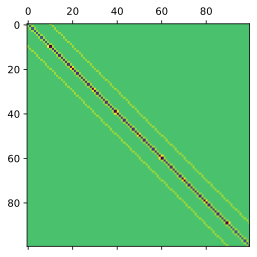

In [433]:
A1 = scipy.sparse.diags([d0, de, dw, dn, ds], [0, 1, -1, nx, -nx], format='csr')
plt.matshow(A1.toarray())

In [434]:
# Initialize variables
## All arrays will be of the size of the grid plus the outside ghost cells
## Staggered grid to the minus side
u = np.zeros((ny+2,nx+2))
v = np.zeros((ny+2,nx+2))
p = np.zeros((ny+2,nx+2))
ut = np.zeros((ny+2,nx+2))  # u_tilde
vt = np.zeros((ny+2,nx+2))  # v_tilde
prhs = np.zeros_like(p)
nsteps = 1
for n in range(nsteps):
    # Boundary conditions
    #u[1:-1,1] = Ul   # Left inlet
    u[-1,1:] = 2.*Ut - u[-2,1:]  # Top wall
    u[0,1:] = 2*Ub - u[1,1:]   # Bottom wall

    v[-1,1:-1] = 0.   # Top wall
    v[1,1:-1] = 0.    # Bottom wall
    v[1:,0] = 2.*Vl - v[1:,1] # Left inlet

    # Solve ut[j,i] = u[j,i] + dt * (-A[j,i] + D[j,i])
    ## u-centered CVs range from indices 2 to nx
    for i in range(2, nx+1):
        for j in range(1,ny+1):
            # Solve for velocities on the surface of a u-centered CV
            ue = 0.5*(u[j,i+1] + u[j,i])
            uw = 0.5*(u[j,i-1] + u[j,i])
            un = 0.5*(u[j+1,i] + u[j,i])
            us = 0.5*(u[j-1,i] + u[j,i])
            vn = 0.5*(v[j+1,i] + v[j+1,i-1])
            vs = 0.5*(v[j,i] + v[j,i-1])
            advection = -(ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy
            diffusion = ν*( (u[j,i+1] - 2*u[j,i] + u[j,i-1])/dx/dx + (u[j+1,i] - 2*u[j,i] + u[j-1,i])/dy/dy )
            ut[j,i] = u[j,i] + dt * (advection + diffusion)
  # Solve vt[j,i] = v[j,i] + dt * (-A[j,i] + D[j,i])
    for i in range(1, nx+1):
        for j in range(2, ny+1):
            ve = 0.5*(v[j,i+1] + v[j,i])
            vw = 0.5*(v[j,i-1] + v[j,i])
            vn = 0.5*(v[j+1,i] + v[j,i])
            vs = 0.5*(v[j-1,i] + v[j,i])
            ue = 0.5*(u[j-1,i+1] + u[j,i+1])
            uw = 0.5*(u[j-1,i] + u[j,i])
            advection = -(vn*vn - vs*vs)/dy - (ue*ve - uw*vw)/dx
            diffusion = ν*( (v[j,i+1] - 2*v[j,i] + v[j,i-1])/dx/dx + (v[j+1,i] - 2*v[j,i] + v[j-1,i])/dy/dy )
            vt[j,i] = v[j,i] + dt * (advection + diffusion)

    # Pressure update -- prhs = 1/dt * div(ut)
    divut = np.zeros((ny+2,nx+2))
    # Velocity divergence occurs on a scalar cell (pressure-centered) since the divergence is a scalar
    ut[1:-1,-1] = ut[1:-1,-2]  #dut/dx = 0 at outlet
    ut[1:-1,1] = Ul + dt * (2*p[1:-1,1] - 2*Pin)/dx
    divut[1:-1,1:-1] = (ut[1:-1,2:] - ut[1:-1,1:-1])/dx + (vt[2:,1:-1] - vt[1:-1,1:-1])/dy
    prhs = 1./dt * divut

    # Sparse linear solver
    pt, info = scipy.sparse.linalg.bicg(A1, prhs[1:-1,1:-1].ravel(), tol=1e-10)
    p = np.zeros_like(u)
    p[1:-1,1:-1] = pt.reshape((ny,nx))
    #p[1:-1,-1] = 2*Pout - p[1:-1,-2]
    p[1:-1,0] = Pin
    #p[1:-1,0] = 2*Pin - p[1:-1,1]

    # Update velocity
    u[1:-1,2:-1] = ut[1:-1,2:-1] - dt * (p[1:-1,2:-1] - p[1:-1,1:-2])/dx
    v[2:-1,1:-1] = vt[2:-1,1:-1] - dt * (p[2:-1,1:-1] - p[1:-2,1:-1])/dy

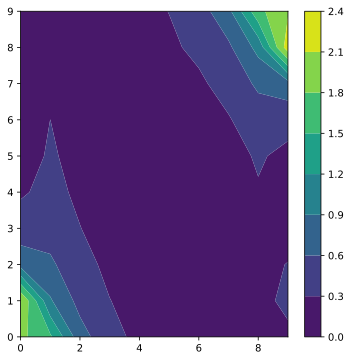

In [435]:
fig = plt.figure(figsize=[6,6],dpi=600)
# Create a coordinate system at the center of the interior cells
ucc = 0.5*(u[1:-1,2:] + u[1:-1,1:-1])
vcc = 0.5*(v[2:,1:-1] + v[1:-1,1:-1])
speed = np.sqrt(ucc*ucc + vcc*vcc)
plt.contourf(speed)
plt.colorbar()

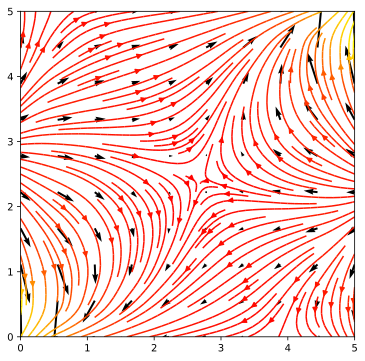

In [436]:
x = np.linspace(0,lx,nx)
y = np.linspace(0,ly,ny)
xx,yy = np.meshgrid(x,y)
nn = 1
fig = plt.figure(figsize=[6,6],dpi=600)
plt.quiver(xx[::nn,::nn],yy[::nn,::nn],ucc[::nn,::nn],vcc[::nn,::nn])
plt.xlim([xx[0,0],xx[0,-1]])
plt.ylim([yy[0,0],yy[-1,0]])
# ax.set_xlim([xx[0,0],xx[0,-1]])
plt.streamplot(xx,yy,ucc, vcc, color=np.sqrt(ucc*ucc + vcc*vcc),density=1.5,cmap=plt.cm.autumn,linewidth=1.5)

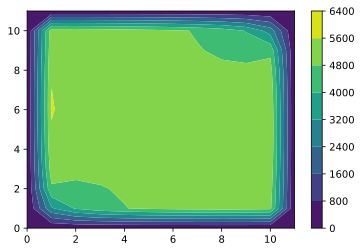

In [437]:
plt.contourf(p)
plt.colorbar()

In [ ]:
def sor_solver(p, A, b, dx, dy):
    pn = np.empty_like(p)
    Ap, Ae, Aw, An, As = A
    it = 0
    err = 1e5
    tol = 1e-8
    maxit = 1000
    β = 1.8
    while err > tol and it < maxit:
        pn = np.copy(p)
        for i in range(1, nx+1):
            for j in range(1, ny+1):
                ap = Ap[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                an = An[j,i]
                as_ = As[j,i]
                rhs = b[j,i] - 1.*(ae*p[j,i+1] + aw*p[j,i-1] + an*p[j+1,i] + as_*p[j-1,i])
                p[j,i] = β*rhs/ap+ (1-β)*p[j,i]
        err = np.linalg.norm(p-pn)
        it += 1
    print(f'SOR solver error: {err}, iterations: {it}')
    return p, err

In [402]:
print(Ap*dx*dx)

[[-2. -3. -3. -3. -3. -3. -3. -3. -3. -2.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -3.]
 [-2. -3. -3. -3. -3. -3. -3. -3. -3. -2.]]


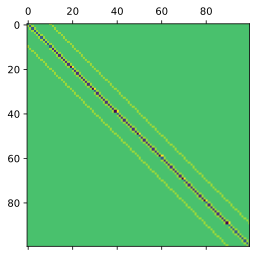

In [325]:
Ap = np.zeros([ny,nx])
Ae = 1.0/dx/dx*np.ones([ny,nx])
As = 1.0/dy/dy*np.ones([ny,nx])
An = 1.0/dy/dy*np.ones([ny,nx])
Aw = 1.0/dx/dx*np.ones([ny,nx])
# set left wall coefs
Aw[:,0] = 0.0
# set right wall coefs
Ae[1:-1,-1] = 2./dx/dx
# set top wall coefs
An[-1,:] = 0.0
# set bottom wall coefs
As[0,:] = 0.0
Ap = -(Aw + Ae + An + As)

n = nx*ny
d0 = Ap.reshape(n)
# print(d0)
de = Ae.reshape(n)[:-1]
# print(de)
dw = Aw.reshape(n)[1:]
# print(dw)
ds = As.reshape(n)[nx:]
# print(ds)
dn = An.reshape(n)[:-nx]
# print(dn)
A1 = scipy.sparse.diags([d0, de, dw, dn, ds], [0, 1, -1, nx, -nx], format='csr')
plt.matshow((A1.toarray()))

In [326]:
print(Ap*dx*dx)

[[-2. -3. -3. -3. -3. -3. -3. -3. -3. -3.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-3. -4. -4. -4. -4. -4. -4. -4. -4. -5.]
 [-2. -3. -3. -3. -3. -3. -3. -3. -3. -3.]]


In [374]:
vt[1:-1,-1] - vt[1:-1,-2]

array([0.        , 0.00011939, 0.00024394, 0.00040113, 0.00063913,
       0.00104169, 0.00174306, 0.00292756, 0.00478338, 0.00738188])

In [391]:
v[-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Current status:

Trying to implements the east and west boundary conditions in the coefficient matrix is proving difficult. There are essentially two velocity sinks at the top right and bottom left corners, and I'm not quite sure why. I t